In [133]:
# important, you need to install scvelo

import os
import numpy as np
import pandas as pd
import scprep
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import magic
from scipy.stats import spearmanr

In [134]:
path_cwd=os.getcwd()
path_train_data=path_cwd + '/ML4G_Project_2_Data/train_data'
path_test_data=path_cwd + '/ML4G_Project_2_Data/test_data'

In [110]:
#train_data
bulk_train=pd.read_csv(path_train_data +'/pancreas_bulk_train.csv',index_col=0)
metadata_train=pd.read_csv(path_train_data+ '/pancreas_sc_metadata_train.csv')
sc_train=scprep.io.load_csv(path_train_data +'/pancreas_sc_train.csv', cell_axis='column')

#test_data
metadata_test=pd.read_csv(path_test_data+ '/pancreas_sc_metadata_test_wocelltype.csv')
sc_test=scprep.io.load_csv(path_test_data +'/pancreas_sc_test.csv', cell_axis='column')

<Axes: xlabel='Library size', ylabel='Number of cells'>

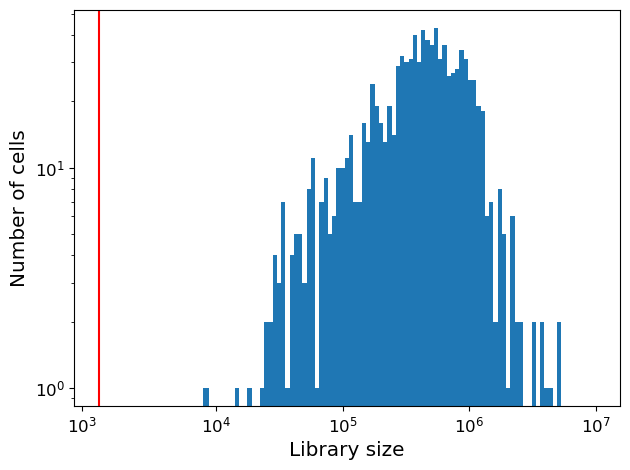

In [111]:
# check the shape of the data
scprep.plot.plot_library_size(sc_train, cutoff=2000)

In [5]:
# filter out genes with low expression
# sc_train = scprep.filter.filter_library_size(sc_train, cutoff=2000)
# not necessary as library sizes are probably already filtered

In [112]:
def sc_filter(sc_data, cutoff=2000, min_cells=10):
    # filter out genes with low expression
    sc_data = scprep.filter.filter_library_size(sc_data, cutoff=cutoff)
    # Filter all genes with negligible counts in all but a few cells.
    sc_data = scprep.filter.filter_rare_genes(sc_data, min_cells=min_cells)
    return sc_data

In [135]:
# Patient cell lists
cells_1=[row for row in sc_train.index if 'patient1' in row]
cells_2=[row for row in sc_train.index if 'patient2' in row]
cells_3=[row for row in sc_train.index if 'patient3' in row]
cells_4=[row for row in sc_train.index if 'patient4' in row]

# For the moment we work only with the first patient
sc1_train=sc_train.loc[cells_1] # we transpose the dataframe since we want a cells x genes dataframe for applying MAGIC
sc1_train.head(3)

Unnamed: 0,SGIP1,AZIN2,CLIC4,AGBL4,NECAP2,SLC45A1,TGFBR3,DBT,RFWD2,C1orf21,...,LOC389831,MGC70870,KIR2DS5,KIR2DL5A,KIR3DS1,KIR2DL5B,KIR2DS2,KIR2DS1,KIR2DL2,KIR2DS3
patient1_A10,0.0,0.0,127.0,0.0,140.0,0.0,0.0,1.0,103.0,267.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient1_A12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient1_A13,0.0,110.0,0.0,21.0,0.0,0.0,0.0,56.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# Preprocessing
def sc_preprocess(sc_data, cutoff=2000, min_cells=0):
    # filter out genes with low expression
    sc_data = sc_filter(sc_data, cutoff=cutoff, min_cells=min_cells)
    # Normalize library sizes
    sc_data = scprep.normalize.library_size_normalize(sc_data)
    # Transform sqrt
    sc_data = scprep.transform.sqrt(sc_data)
    return sc_data

sc1_train_pp = sc_preprocess(sc1_train)
sc1_train_pp.head(3)

Unnamed: 0,SGIP1,AZIN2,CLIC4,AGBL4,NECAP2,SLC45A1,TGFBR3,DBT,RFWD2,C1orf21,...,LOC389831,MGC70870,KIR2DS5,KIR2DL5A,KIR3DS1,KIR2DL5B,KIR2DS2,KIR2DS1,KIR2DL2,KIR2DS3
patient2_A12,0.000000,0.000000,0.0,0.0,1.062808,0.475302,0.00000,0.672179,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient2_A14,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient2_A15,0.473466,0.946932,0.0,0.0,0.473466,0.000000,2.36733,0.473466,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
# MAGIC
sc1_train_magic = magic.MAGIC(n_pca=1000,
                              t='auto',
                                knn=50,
                                decay=1,
                                n_jobs=8,
                                random_state=0,
                                verbose=2
                              ).fit_transform(sc1_train_pp)
sc1_train_magic.head(3)

Calculating MAGIC...
  Running MAGIC on 234 cells and 25453 genes.
  Calculating graph and diffusion operator...
    Building knn graph
    Initializing [<class 'graphtools.graphs.kNNGraph'>] with arguments bandwidth_scale='1.0', thresh='0.0001', decay='1', distance='euclidean', random_state='0', anisotropy='0', bandwidth='None', theta='None', rank_threshold='None', verbose='2', n_pca='1000', kernel_symm='+', knn_max='150', initialize='True', knn='50', n_jobs='8'
    Initializing kernel...
    Calculating KNN search...
    Calculated KNN search in 1.10 seconds.
    Calculating affinities...
      search_knn = 151; 234 remaining
      knn search to knn_max (151) on 234
    Calculated affinities in 0.39 seconds.
    Using addition symmetrization.
  Calculated graph and diffusion operator in 1.53 seconds.
  Running MAGIC with `solver='exact'` on 25453-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calcul

Unnamed: 0,SGIP1,AZIN2,CLIC4,AGBL4,NECAP2,SLC45A1,TGFBR3,DBT,RFWD2,C1orf21,...,LOC389831,MGC70870,KIR2DS5,KIR2DL5A,KIR3DS1,KIR2DL5B,KIR2DS2,KIR2DS1,KIR2DL2,KIR2DS3
patient2_A12,0.074506,0.133203,0.405875,0.032688,0.647121,0.117907,0.350706,0.251031,0.482476,0.262213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient2_A14,0.081502,0.140030,0.395692,0.035985,0.644375,0.126576,0.367816,0.249683,0.482611,0.257167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
patient2_A15,0.082722,0.141226,0.393922,0.036560,0.643913,0.128092,0.370785,0.249450,0.482649,0.256288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
# remove list of elements from a list
filtered_genes = [gene for gene in sc_train.columns if gene not in sc1_train_magic.columns]
filtered_genes_df = pd.DataFrame(0, index=filtered_genes, columns=['genes'])

In [116]:
# add filtered genes to magic dataframe
pred = sc1_train_magic.mean(axis=0)
pred = pd.DataFrame(pred, columns=['genes'])
pred_all = pd.concat([pred, filtered_genes_df], axis=0)
pred_all = pred_all.reindex(sc_train.columns)

In [29]:
from itertools import product

results=[]
k_set, t_set , n_pca_set= [5], [5], [200]#[2,4,6,8,10], [2,3,4,6,8], [100,200,300]
for k,t, n_pca in product(k_set,t_set,n_pca_set):
    magic_op = magic.MAGIC(verbose=0,knn=k,t=t,n_pca=n_pca)
    imputed = magic_op.fit_transform(sc1_train)
    pred=imputed.mean(axis=0)
    bulk=bulk_train['patient1']
    results+=[spearmanr(pred,bulk).statistic]

/home/mike/.local/lib/python3.9/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/mike/.local/lib/python3.9/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/mike/.local/lib/python3.9/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


  Running MAGIC with `solver='exact'` on 25453-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/mike/.local/lib/python3.9/site-packages/magic/magic.py:586: DeprecationWarning: Call to deprecated method warning. (Use TaskLogger.log_warning instead) -- Deprecated since version 1.1.0.
  _logger.warning(
/home/mike/.local/lib/python3.9/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


In [47]:
pred_all

,genes
SGIP1,0.041776
AZIN2,0.143125
CLIC4,0.143307
AGBL4,0.070990
NECAP2,0.256567
...,...
KIR2DL5B,0.000000
KIR2DS2,0.000000
KIR2DS1,0.000000
KIR2DL2,0.000000


In [46]:
bulk_train['patient1']

level_0
SGIP1        360
AZIN2        388
CLIC4       3679
AGBL4        118
NECAP2      1522
            ... 
KIR2DL5B       0
KIR2DS2        0
KIR2DS1        0
KIR2DL2        0
KIR2DS3        0
Name: patient1, Length: 25453, dtype: int64

In [120]:
baseline=spearmanr(sc1_train.mean(axis=0),bulk_train['patient2']).statistic
score=spearmanr(pred_all,bulk_train['patient2']).statistic
print(f'Correlation before imputation: {baseline}')
print(f'Best Correlation: {score}')

Correlation before imputation: 0.9409002656770739
Best Correlation: 0.9290172433856854


# Draft

In [ ]:
# To do: HPO for MAGIC
from sklearn.base import BaseEstimator

# CREATION OF SCORE FUNCTION
def score_func(y, y_pred):
    return spearmanr(y,y_pred).statistic

scorer=make_scorer(score_func) #needed to be able to use spearmanr as score function in scikit-learn

class custom_magic(BaseEstimator):
    def __init__(self,k=5,t=3,n_pca=100):
        self.k=k
        self.t=t
        self.n_pca=n_pca
        self.model=magic.MAGIC(verbose=0,knn=k,t=t,n_pca=n_pca)

    def fit(self, X, y=None):
        return None

    def predict(self, X):
        raw=self.model.fit_transform(X)
        return raw.mean(axis=0)


    def set_params(self, **params):
        if not params:
            return self

        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                self.kwargs[key] = value
        return self

param_grid= {'k':[1,2,3,5],'t':[1,2,3], 'n_pca':[10,20,30]}

from sklearn.model_selection import GridSearchCV

GridSearchCV(custom_magic(), param_grid,cv=,scoring=score_func())